# Anomaly Detection: univariate ARIMA and multivariate VAR

The notebook here follows the notebook from Marco Cerliani: https://github.com/cerlymarco/MEDIUM_NoteBook/blob/master/Anomaly_Detection_VAR/Anomaly_Detection_VAR.ipynb

The content is associate witht the blog [Anomaly Detection in Multivariate Time Series with VAR](https://towardsdatascience.com/anomaly-detection-in-multivariate-time-series-with-var-2130f276e5e9)

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

## 0. Data source 

[Seattle Burke Gilman Trail](https://www.kaggle.com/datasets/city-of-seattle/seattle-burke-gilman-trail)

The dataset stores hourly counting series detected by sensors. These sensors count both people riding bikes and pedestrians; 2 related to pedestrian count, 2 related to bike count. **BGT North of NE 70th Total** is the total count.

In [25]:
train_hours = 80*7*24  # weeks x hours x days
test_hours = 15*7*24  # weeks x hours x days

df = pd.read_csv('data/bike_ped_counter.csv', nrows=train_hours+test_hours, parse_dates=['Date'])

print(df.shape)
df.head()

(15960, 6)


,Date,BGT North of NE 70th Total,Ped South,Ped North,Bike North,Bike South
0,2014-01-01 00:00:00,15.0,0.0,2.0,2.0,11.0
1,2014-01-01 01:00:00,9.0,1.0,0.0,1.0,7.0
2,2014-01-01 02:00:00,9.0,0.0,0.0,0.0,9.0
3,2014-01-01 03:00:00,19.0,0.0,0.0,0.0,19.0
4,2014-01-01 04:00:00,19.0,0.0,0.0,0.0,19.0


### 0.1 Missing data imputation

In [26]:
df['Ped South'] = df['Ped South'].groupby(df.Date.dt.hour).transform(lambda x: x.fillna(x.median()))
df['Ped North'] = df['Ped North'].groupby(df.Date.dt.hour).transform(lambda x: x.fillna(x.median()))
df['Bike South'] = df['Bike South'].groupby(df.Date.dt.hour).transform(lambda x: x.fillna(x.median()))
df['Bike North'] = df['Bike North'].groupby(df.Date.dt.hour).transform(lambda x: x.fillna(x.median()))
df['BGT North of NE 70th Total'] = df['Ped South'] + df['Ped North'] + df['Bike South'] + df['Bike North']

### 0.2 Deal with daily seasonality

NOTE, Marco's code in the github doesn't work. To aggregated daily, we need to group by `df.Date.dt.date`.

(665, 5)


<AxesSubplot:xlabel='Date'>

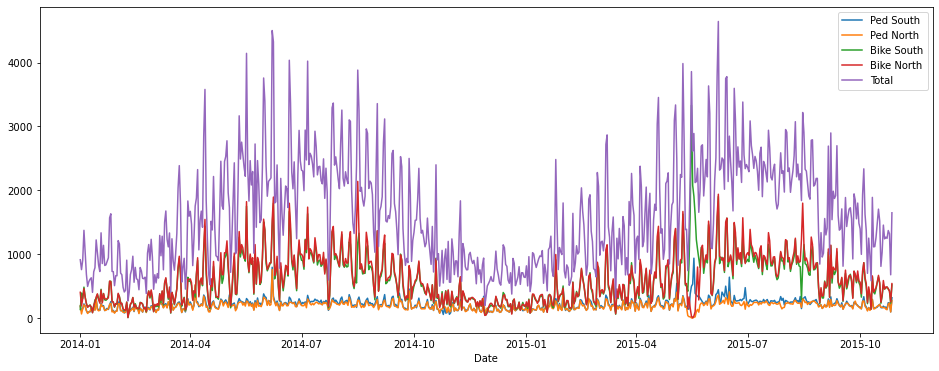

In [38]:
### DAILY AGGREGATION ###

df_day = pd.DataFrame()
df_day['Ped South'] = df.groupby(df.Date.dt.date)['Ped South'].sum()
df_day['Ped North'] = df.groupby(df.Date.dt.date)['Ped North'].sum()
df_day['Bike South'] = df.groupby(df.Date.dt.date)['Bike South'].sum()
df_day['Bike North'] = df.groupby(df.Date.dt.date)['Bike North'].sum()
df_day['Total'] = df.groupby(df.Date.dt.date)['BGT North of NE 70th Total'].sum()

print (df_day.shape)
df_day.plot(figsize=(16,6))

### 0.3 autocorrelation

In [36]:
train = df_day[:(train_hours//24)].copy()

train.shape

(560, 5)

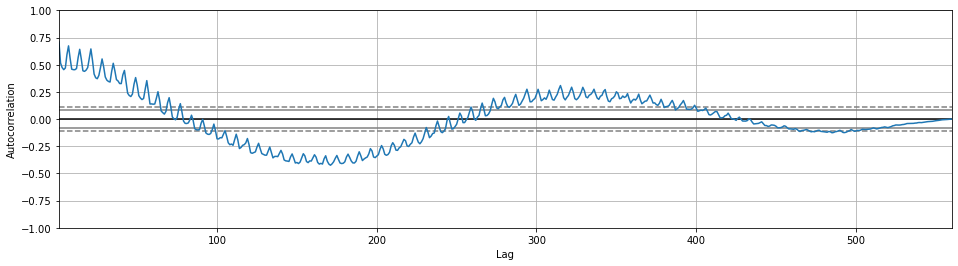

In [41]:
### TOTAL COUNT TRAIN AUTOCORR ###

plt.figure(figsize=(16,4))
pd.plotting.autocorrelation_plot(train['Total'])
plt.show()

## 0.4 Remove Month Seasonality

In [15]:
month_mean_train = train.groupby(train.index.month).mean()

In [16]:
train['Ped South'] = train.apply(lambda x: x['Ped South'] - month_mean_train['Ped South'][x.name.month], axis=1)
train['Ped North'] = train.apply(lambda x: x['Ped North'] - month_mean_train['Ped North'][x.name.month], axis=1)
train['Bike South'] = train.apply(lambda x: x['Bike South'] - month_mean_train['Bike South'][x.name.month], axis=1)
train['Bike North'] = train.apply(lambda x: x['Bike North'] - month_mean_train['Bike North'][x.name.month], axis=1)
train['Total'] = train.apply(lambda x: x['Total'] - month_mean_train['Total'][x.name.month], axis=1)

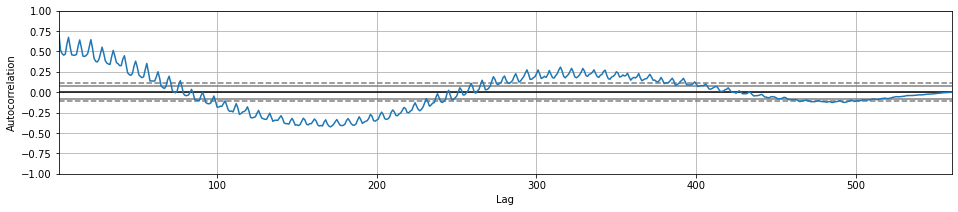

In [44]:
### TOTAL COUNT TRAIN AUTOCORR ###

plt.figure(figsize=(16, 3))
pd.plotting.autocorrelation_plot(train['Total'])
plt.show()

## 1. Univariate Anomaly Detection - ARIMA

**univariate variable**: total count

In [50]:
type(test_uni)

pandas.core.series.Series

In [46]:
test_uni.index

Index([2015-07-15, 2015-07-16, 2015-07-17, 2015-07-18, 2015-07-19, 2015-07-20,
       2015-07-21, 2015-07-22, 2015-07-23, 2015-07-24,
       ...
       2015-10-18, 2015-10-19, 2015-10-20, 2015-10-21, 2015-10-22, 2015-10-23,
       2015-10-24, 2015-10-25, 2015-10-26, 2015-10-27],
      dtype='object', name='Date', length=105)

In [88]:
df_day[(train_hours//24):].copy().head(20)

,Ped South,Ped North,Bike South,Bike North,Total
Date,,,,,
2015-07-15,259.0,238.0,943.0,959.0,2399.0
2015-07-16,271.0,268.0,835.0,890.0,2264.0
2015-07-17,290.0,242.0,759.0,840.0,2131.0
2015-07-18,244.0,207.0,1152.0,1337.0,2940.0
2015-07-19,224.0,197.0,1037.0,1210.0,2668.0
2015-07-20,271.0,240.0,815.0,879.0,2205.0
2015-07-21,267.0,241.0,818.0,836.0,2162.0
2015-07-22,263.0,224.0,880.0,955.0,2322.0
2015-07-23,277.0,237.0,934.0,960.0,2408.0


In [86]:
test_uni.head()

,Ped South,Ped North,Bike South,Bike North,Total,year_month
Date,,,,,,
2015-07-15,259.0,238.0,943.0,959.0,-35729.0,2015-07
2015-07-16,271.0,268.0,835.0,890.0,-35864.0,2015-07
2015-07-17,290.0,242.0,759.0,840.0,-35997.0,2015-07
2015-07-18,244.0,207.0,1152.0,1337.0,-35188.0,2015-07
2015-07-19,224.0,197.0,1037.0,1210.0,-35460.0,2015-07


In [85]:
train_uni = train['Total'].copy()

test_uni = df_day[(train_hours//24):].copy()

test_uni["year_month"] = [x.strftime('%Y-%m') for x in test_uni.index] 

# test_uni["month"] = pd.DatetimeIndex(test_uni.index).month
# test_uni["year"] = pd.DatetimeIndex(test_uni.index).year
month_mean_test = test_uni[["year_month", "Total"]].groupby(by=["year_month"]).sum()

# df.groupby(by=["b"]).sum()


test_uni['Total'] = test_uni.apply(lambda x: x['Total'] - month_mean_test['Total'][x.year_month], axis=1)
# test_uni = test_uni - test_uni.index.month.map(month_mean_train['Total'])

# train.drop('Total', inplace=True, axis=1)

## 2. Multivariate Anomaly detection - VAR